# Think Bayes

This notebook presents code and exercises from Think Bayes, second edition.

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import math
import numpy as np

from thinkbayes2 import Pmf, Cdf, Suite
import thinkplot

### The flea beetle problem

Different species of flea beetle can be distinguished by the width and angle of the aedeagus.  The data below includes measurements and know species classification for 74 specimens.

Suppose you discover a new specimen under conditions where it is equally likely to be any of the three species.  You measure the aedeagus and width 140 microns and angle 15 (in multiples of 7.5 degrees).  What is the probability that it belongs to each species?


This problem is based on [this data story on DASL](https://web.archive.org/web/20160304083805/http://lib.stat.cmu.edu/DASL/Datafiles/FleaBeetles.html)

Datafile Name: Flea Beetles

Datafile Subjects: Biology

Story Names: Flea Beetles

Reference: Lubischew, A.A. (1962) On the use of discriminant functions in taxonomy. Biometrics, 18, 455-477. Also found in: Hand, D.J., et al. (1994) A Handbook of Small Data Sets, London: Chapman & Hall, 254-255.

Authorization: Contact Authors

Description: Data were collected on the genus of flea beetle Chaetocnema, which contains three species: concinna (Con), heikertingeri (Hei), and heptapotamica (Hep). Measurements were made on the width and angle of the aedeagus of each beetle. The goal of the original study was to form a classification rule to distinguish the three species.

Number of cases: 74

Variable Names:

Width: The maximal width of aedeagus in the forpart (in microns)

Angle: The front angle of the aedeagus (1 unit = 7.5 degrees)

Species: Species of flea beetle from the genus Chaetocnema


We can read the data from this file:

In [2]:
import pandas as pd

df = pd.read_csv('../data/flea_beetles.csv', delimiter='\t')
df.head()

,Width,Angle,Species
0,150,15,Con
1,147,13,Con
2,144,14,Con
3,144,16,Con
4,153,13,Con


Here's what the distributions of width look like.

In [3]:
def plot_cdfs(df, col):
    for name, group in df.groupby('Species'):
        cdf = Cdf(group[col], label=name)
        thinkplot.Cdf(cdf)
    
    thinkplot.decorate(xlabel=col, 
                       ylabel='CDF',
                       loc='lower right')

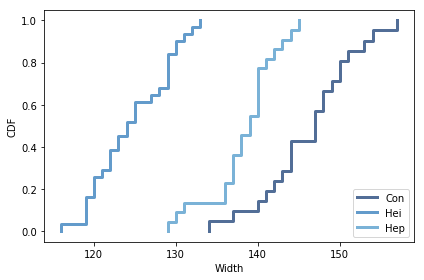

In [4]:
plot_cdfs(df, 'Width')

And the distributions of angle.

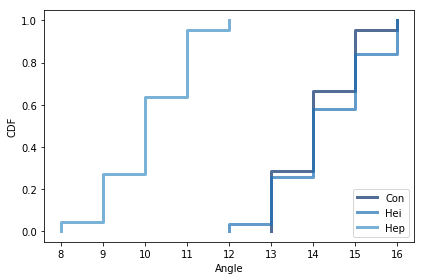

In [5]:
plot_cdfs(df, 'Angle')

I'll group the data by species and compute summary statistics.

In [6]:
grouped = df.groupby('Species')

Here are the means.

In [7]:
means = grouped.mean()

,Width,Angle
Species,,
Con,146.190476,14.095238
Hei,124.645161,14.290323
Hep,138.272727,10.090909


And the standard deviations.

In [8]:
stddevs = grouped.std()

,Width,Angle
Species,,
Con,5.626891,0.889087
Hei,4.622758,1.101319
Hep,4.142484,0.971454


And the correlations.

In [9]:
for name, group in grouped:
    corr = group.Width.corr(group.Angle)
    print(name, corr)

Con -0.193701151757636
Hei -0.06420611481268008
Hep -0.12478515405529574


Those correlations are small enough that we can get an acceptable approximation by ignoring them, but we might want to come back later and write a complete solution that takes them into account.

### The likelihood function

To support the likelihood function, I'll make a dictionary for each attribute that contains a `norm` object for each species.

In [10]:
from scipy.stats import norm

dist_width = {}
dist_angle = {}
for name, group in grouped:
    dist_width[name] = norm(group.Width.mean(), group.Width.std())
    dist_angle[name] = norm(group.Angle.mean(), group.Angle.std())

Now we can write the likelihood function concisely.

In [11]:
class Beetle(Suite):
    
    def Likelihood(self, data, hypo):
        """
        data: sequence of width, height
        hypo: name of species
        """
        width, angle = data
        name = hypo
        
        like = dist_width[name].pdf(width)
        like *= dist_angle[name].pdf(angle)
        return like

The hypotheses are the species names:

In [12]:
hypos = grouped.groups.keys()

dict_keys(['Con', 'Hei', 'Hep'])

We'll start with equal priors

In [13]:
suite = Beetle(hypos)
suite.Print()

Con 0.3333333333333333
Hei 0.3333333333333333
Hep 0.3333333333333333


Now we can update with the data and print the posterior.

In [14]:
suite.Update((140, 15))
suite.Print()

Con 0.9902199258865487
Hei 0.009770186966082915
Hep 9.887147368342703e-06


Based on these measurements, the specimen is very likely to be an example of *Chaetocnema concinna*.